# Part 2 - Data Exploration

### First, let's start by importing everything

In [1]:
from proj2.config import PROJ_ROOT, DATA_DIR, MODELS_DIR, REPORTS_DIR, FIGURES_DIR

2025-04-22 19:01:39.069 | INFO     | proj2.config:<module>:29 - PROJ_ROOT path is: /Users/francescobondi/Desktop/stuff/ETH/FS25/ML for Healthcare/project-2-ml4hc


---

## Load data

In [2]:
from proj2.part2.dataloader import get_data_set_loader

train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = get_data_set_loader()

BASE_DIR: /Users/francescobondi/Desktop/stuff/ETH/FS25/ML for Healthcare/project-2-ml4hc/data/external/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Classes: ['NORMAL', 'PNEUMONIA']
Train samples: 5216
Val   samples: 16
Test  samples: 624


---

# Q1.1 - Exploration of Data

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count labels in train dataset
label_names = train_dataset.classes  # ['NORMAL', 'PNEUMONIA']
label_counts = Counter([label for _, label in train_dataset])

# Plot
plt.bar(label_names, [label_counts[0], label_counts[1]], color=["skyblue", "salmon"])
plt.title("Label Distribution in Train Set")
plt.ylabel("Number of Samples")
plt.show()


In [ ]:
def get_one_sample_per_class(dataset):
    seen = set()
    samples = {}

    for img, label in dataset:
        if label not in seen:
            samples[label] = img
            seen.add(label)
        if len(seen) == len(dataset.classes):
            break
    return samples

samples = get_one_sample_per_class(train_dataset)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, label in enumerate(sorted(samples.keys())):
    axes[i].imshow(samples[label].permute(1, 2, 0), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_dataset.classes[label]}")

plt.suptitle("One Sample per Class")
plt.tight_layout()
plt.show()


# Q1.2 - Visual Differences

In the case of NORMAL lungs, the lungs appear clear and distinguishable. PNEUMONIA, instead, shows cloudy lungs and not completely visbile, indicating a possible fluid or injection.

---

# Q1.3 - Potential Source of Bias

One great problem could be that the model learns to classify samples by looking at scanner-specific artifacts. Also, in this case we have some class imbalanceness, since the PNEUMONIA samples are more than 2x the samples of NORMAL lungs.

---

# Q1.4

The data is already transformed when loaded inside the datasets. The transformation used is:

```
 image_transform = transforms.Compose(
        [
            transforms.Resize(image_size),  # ^ Change this to the desired size
            transforms.ToTensor(),
        ]
    )
```

However, this could be further changed to include a reduction to grayscale, and a final normalization of pixel values.

---

# Q2 - CNN Classifier

## Q2.1 - Simple CNN

In [3]:
# Simple CNN Model
import torch.nn.functional as F
import torch.nn as nn
import torch

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # input is grayscale (1 channel)
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),  # Binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Q2.2 - Performance of Test Set

It's not clear, should I train it first? Or is it zero-shot classification?

## Train the model

In [ ]:
from proj2.part2.training import train_CNN, eval_CNN

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_CNN(model, train_loader, val_loader, optimizer, criterion, num_epochs, device)

## Now do the evaluation

In [ ]:
from proj2.config import PROJ_ROOT
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "model_final.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
# Evaluate the model
eval_CNN(model, test_loader, device=device)

---
# Q3 - Integrated Gradients

Attrib:   0%|          | 0/10 [00:00<?, ?it/s]

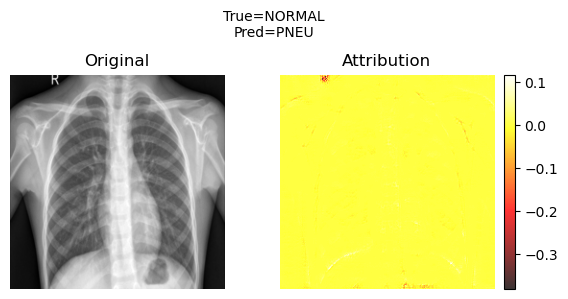

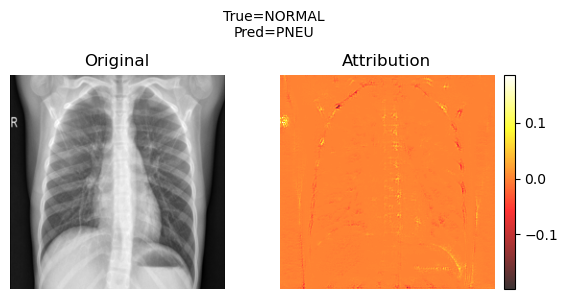

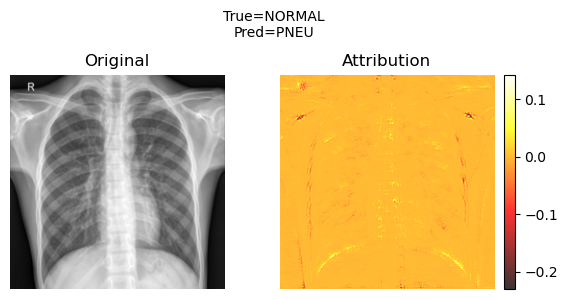

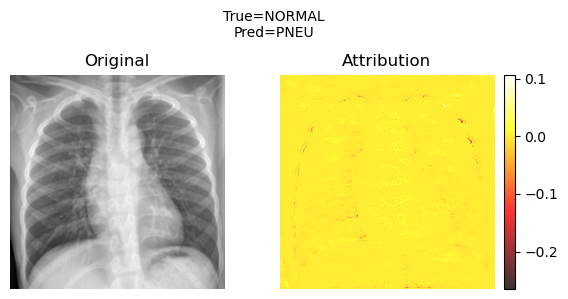

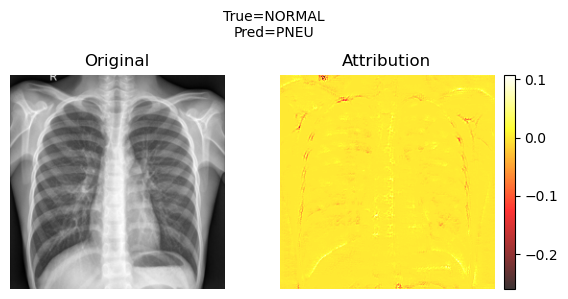

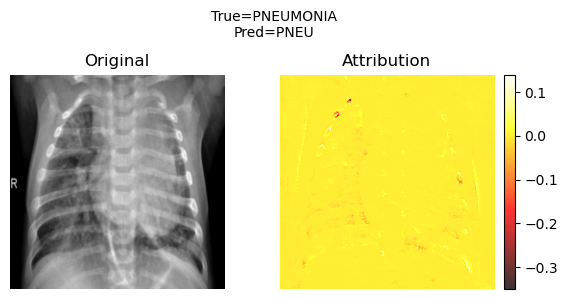

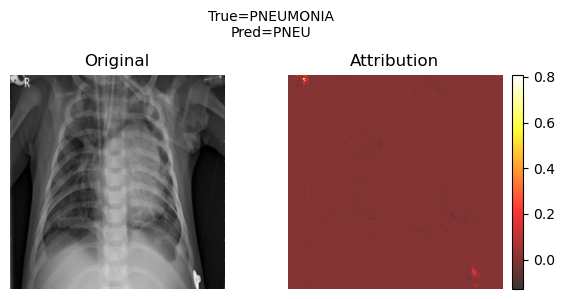

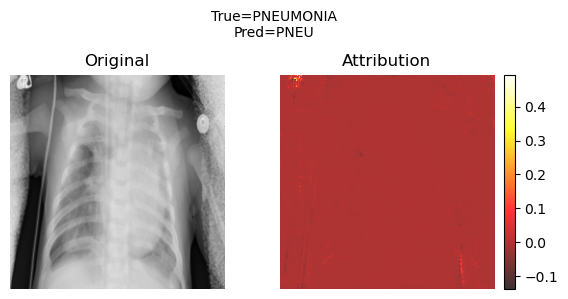

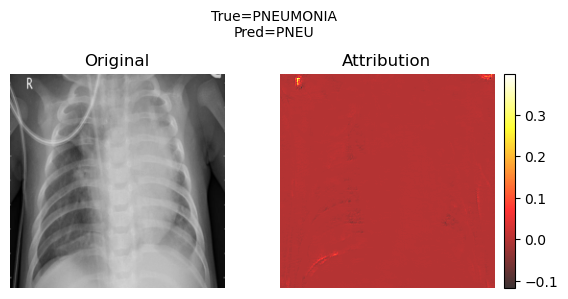

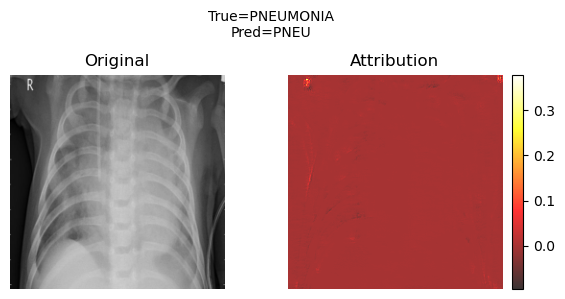

In [ ]:
from captum.attr import IntegratedGradients
from torch.utils.data import Subset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "model_final.pt"
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.eval()




# 2. Set up Integrated Gradients
ig = IntegratedGradients(model)

# Pick 5 normals (label=0) and 5 pneumonia (label=1)
idx_norm = [i for i, (_, lbl) in enumerate(test_dataset) if lbl==0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_dataset) if lbl==1][:5]
subset = Subset(test_dataset, idx_norm + idx_pneu)
loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

# 3. Helper to visualize attribution
def show_attr(attr, orig_img, title=None, save_path=None):
    """
    attr: numpy [1,224,224], orig_img: numpy [224,224]
    """
    fig, axes = plt.subplots(1,2, figsize=(6,3))
    # original
    axes[0].imshow(orig_img, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title("Original")
    # heatmap
    im = axes[1].imshow(attr, cmap="hot", alpha=0.8)
    axes[1].axis("off")
    axes[1].set_title("Attribution")
    fig.suptitle(title, fontsize=10)
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

# 4. Compute and plot
for idx, (img, lbl) in enumerate(tqdm(loader, desc="Attrib")):
    img = img.to(device)                      # [1,1,224,224]
    lbl = lbl.item()
    # Compute Integrated Gradients wrt the predicted class
    img.requires_grad_()
    pred = model(img)
    pred_class = torch.sigmoid(pred).item() >= 0.5
    target = int(pred_class)                  # use model’s own decision
    attributions, delta = ig.attribute(
        img,
        baselines=img * 0,
        target=0,              # ← must be zero for a single-output model
        n_steps=50,
        return_convergence_delta=True
    )
    # convert to CPU numpy
    attr = attributions.cpu().detach().numpy()[0,0]
    original = img.cpu().detach().numpy()[0,0]
    label_map = {0: "NORMAL", 1: "PNEUMONIA"}
    cls_name = label_map[lbl]
    title = f"True={cls_name}\nPred={'PNEU' if pred_class else 'NORM'}"
    pred_name = "PNEU" if pred_class else "NORM"

    # build a filename like "03_NORMAL_pred-PNEU.png"
    fname = f"{idx:02d}_{cls_name}_pred-{pred_name}.png"
    save_path = FIG_DIR / fname

    show_attr(attr, original, title=title, save_path=save_path)

### Comment:

The brightest colors (white/yellow) indicate that the area has been very relevant in predicting the outcome. Dark colors indicate that they were contributing negatively (push to the other class).

---

## Q3.2 - Do the maps highlight sensible regions?

Yes, the attribution maps generally highlight clinically relevant regions of the lungs. In samples labeled PNEUMONIA, high-attribution areas often appear around localized cloudy regions or infiltrates, which is consistent with where abnormalities manifest. For NORMAL cases, the attributions are more evenly distributed or focus on the lung outlines and areas free of occlusions.

---

## Q3.3 — Are attributions consistent across samples?

Mostly yes. Across different PNEUMONIA samples, attribution maps consistently highlight patchy, high-opacity regions, even though their locations vary (left vs. right lung, upper vs. lower lobes). For NORMAL cases, the attributions tend to focus on central lung zones and edges, which are structurally stable across patients.

However, small variations can occur depending on pose, cropping, or scanner noise. These are expected in medical images, and the general pattern of focusing on lung areas is preserved.

---

## Q3.4 — Does the choice of baseline input image have a big effect on the attribution maps?

Yes — the baseline image is crucial in Integrated Gradients. In your code, you used a black image (img * 0) as the baseline, which is standard and often effective. However:

A zero baseline can exaggerate gradients near the edges or dark regions (e.g., lung borders).
Using a blurred version of the image, a mean image, or a uniform gray image as a baseline can reduce noise in the attributions.
Different baselines can result in shifts in the spatial focus of the attributions — especially for borderline cases.

---

# Q4 - Grad-CAM

In [10]:
# 1) Define a GradCAM helper
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients   = None

        # register hooks
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_in, grad_out):
        # grad_out is a tuple; we want the gradients wrt the layer's output
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, target_index):
        """
        input_tensor: shape [1, C, H, W]
        target_index: index of the logit to explain (0 for single-output)
        """
        self.model.zero_grad()
        output = self.model(input_tensor)             # forward
        # If single-output, output is shape [1,1]; pick [0,0]
        score  = output[0, target_index]              # scalar logit
        score.backward(retain_graph=True)             # backward

        # pull out the saved activations + gradients
        activations = self.activations[0]              # [K, h, w]
        gradients   = self.gradients[0]                # [K, h, w]

        # global-average-pool the gradients into weights
        weights = gradients.mean(dim=(1,2))            # [K]

        # linear combination of weights * activations
        cam = torch.zeros_like(activations[0])
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = torch.relu(cam)                          # remove negatives
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)                 # normalize to [0,1]

        # upsample to input size
        cam = cam.unsqueeze(0).unsqueeze(0)            # [1,1,h,w]
        cam = torch.nn.functional.interpolate(
            cam,
            size=input_tensor.shape[2:],
            mode='bilinear',
            align_corners=False
        )[0,0]                                        # [H,W]
        return cam.cpu().numpy()

In [11]:
# 2) Prepare model & data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
checkpoint = torch.load(PROJ_ROOT/"models"/"cnn"/"model_final.pt", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [12]:
# choose the last conv layer in SimpleCNN.features
target_layer = model.features[6]  # the third Conv2d
gradcam = GradCAM(model, target_layer)

In [13]:
# Pick 5 normals (label=0) and 5 pneumonia (label=1)
idx_norm = [i for i, (_, lbl) in enumerate(test_dataset) if lbl==0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_dataset) if lbl==1][:5]
subset = Subset(test_dataset, idx_norm + idx_pneu)
loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

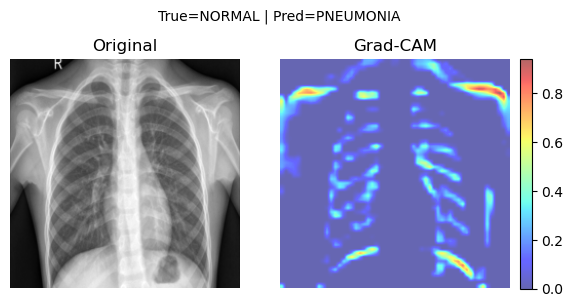

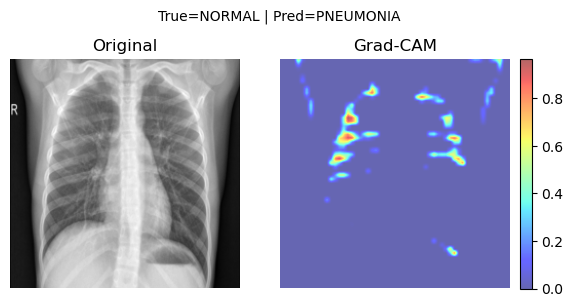

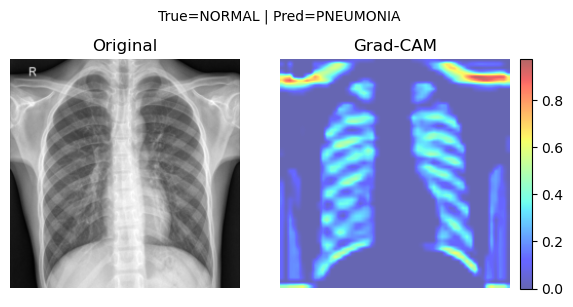

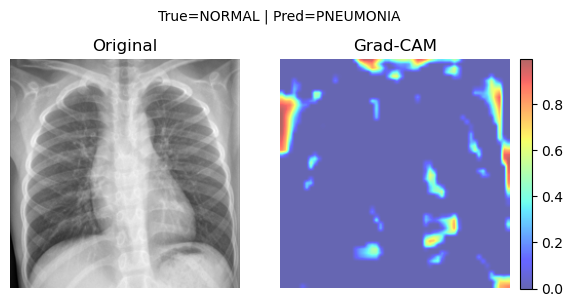

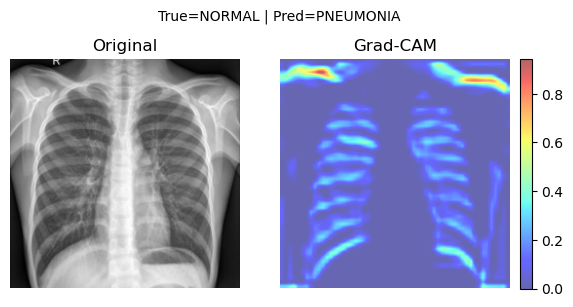

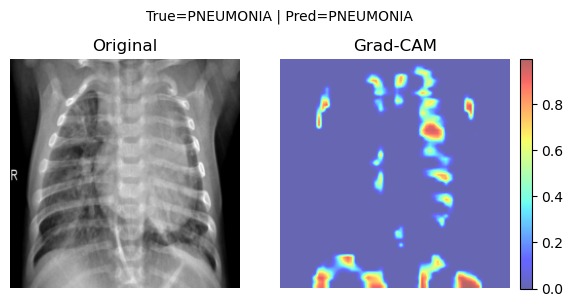

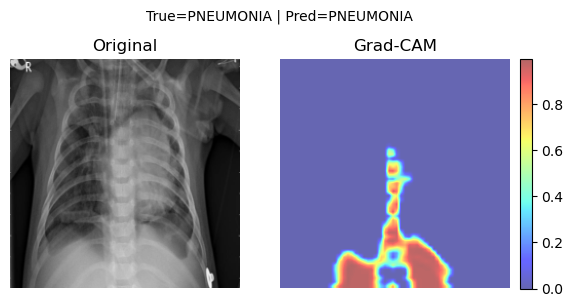

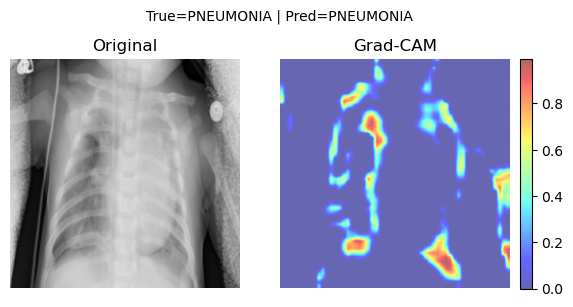

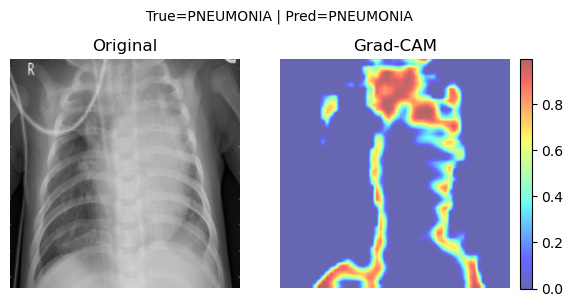

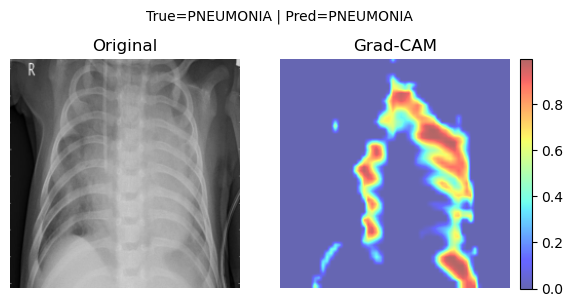

In [15]:
FIG_DIR = PROJ_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 3) Visualization helper
def show_gradcam(cam, orig, title=None, save_path=None):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
    ax1.imshow(orig, cmap="gray")
    ax1.axis("off"); ax1.set_title("Original")
    im = ax2.imshow(cam, cmap="jet", alpha=0.6)
    ax2.axis("off"); ax2.set_title("Grad‑CAM")
    if title: fig.suptitle(title, fontsize=10)
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()


# 4) Compute & plot
label_map = {0:"NORMAL",1:"PNEUMONIA"}
for idx, (img, lbl) in enumerate(loader):
    img = img.to(device)
    lbl = lbl.item()
    # forward to get predicted class
    logit = model(img)
    pred = (torch.sigmoid(logit) >= 0.5).long().item()

    # compute GradCAM heatmap
    cam = gradcam.generate(img, target_index=0)

    # undo normalization for visualization
    inv = img.cpu().squeeze(0).squeeze(0).numpy()
    inv = inv*0.5 + 0.5  # back to [0,1] range

    title = f"True={label_map[lbl]} | Pred={label_map[pred]}"
    true_label = label_map[lbl]
    pred_label = label_map[pred]
    fname = f"{idx:02d}_{true_label}_pred-{pred_label}_gradcam.png"
    save_path = FIG_DIR / fname
    show_gradcam(cam, inv, title=title, save_path=save_path)

### Comment on GradCAM

Grad-CAM highlights which regions in the image influenced the model’s prediction the most. The color intensity in the heatmap reflects the importance of each spatial region:
- Red/Yellow (Hot) → High contribution: these areas strongly influenced the model toward its predicted class.
- Blue/Dark → Low contribution: these areas had little or no impact on the model’s decision.

In practice, we expect:
- PNEUMONIA cases to show red/yellow highlights over cloudy or inflamed lung regions.
- NORMAL cases to show more diffuse or empty activations across the lung fields.

---

## Q4.2 - Do the maps highlight sensible regions?

Yes.
Grad-CAM maps consistently highlight lung regions, especially areas where the model likely detects abnormalities. In PNEUMONIA samples, high-activation zones appear over cloudy or patchy textures, which correspond to infection or fluid buildup. In NORMAL samples, the activation is either spread more evenly or focused around anatomically relevant structures, such as lung boundaries or central chest regions.

🖼️ Figure Suggestion: Include 1–2 side-by-side examples showing original vs. Grad-CAM overlay for both NORMAL and PNEUMONIA cases.

---

## Q4.3 — Are attributions consistent across samples?

Mostly, yes.
Across PNEUMONIA samples, Grad-CAM tends to focus on localized areas of increased opacity—regardless of where in the lungs they occur (left/right, upper/lower lobes). NORMAL cases exhibit more distributed or less intense activation, showing that the model relies on broader context in the absence of disease.

This consistency suggests that the model is learning a reliable spatial pattern for detecting pneumonia.

🖼️ Figure Suggestion: Show a 2×5 grid (or two rows of 5 images each) with Grad-CAM overlays for multiple NORMAL and PNEUMONIA test samples.

---

## Q4.4 — Compare your findings with Q3

Grad-CAM and Integrated Gradients (IG) offer complementary insights into model behavior. Grad-CAM produces coarse, region-level heatmaps that highlight where the model is focusing its attention, typically aligning with semantically meaningful areas like lung regions with visible opacity. In contrast, IG provides fine-grained, pixel-level attributions that reveal which specific pixels contribute most to the prediction. Grad-CAM is generally more interpretable and stable across samples, making it well-suited for visual explanations in medical imaging. IG, while more sensitive to subtle variations, is dependent on the choice of baseline, which can influence the results significantly. Overall, Grad-CAM excels in providing a high-level overview of spatial attention, while IG is more informative for understanding low-level pixel interactions. Using both methods together can provide a deeper understanding of model decisions.

---